In [1]:
%%writefile requirements.txt

contextily
geopandas
folium
h5py
harmony-py
IPython
matplotlib
matplotlib_scalebar
netCDF4
numpy
owslib
pandas
pydap
rasterio
rasterstats
requests
s3fs
seaborn
scipy
shapely
tabulate
blosc2
cython
pyqt5
pyqtwebengine
FuzzyTM
cartopy
scipy
richdem
GDAL

Writing requirements.txt


In [3]:
%pip install -r requirements.txt

  Obtaining dependency information for harmony-py from https://files.pythonhosted.org/packages/44/d0/15e203f3fdea8e1e0ca5f592c3822456ad7400a886a0041aadb56f16f8bb/harmony_py-0.4.15-py3-none-any.whl.metadata
  Using cached harmony_py-0.4.15-py3-none-any.whl.metadata (6.8 kB)
  Obtaining dependency information for matplotlib_scalebar from https://files.pythonhosted.org/packages/a9/9e/22930e3deb2c374f47c6633aff9f6f379f8c421ab868fff3b4f85eac8b8a/matplotlib_scalebar-0.8.1-py2.py3-none-any.whl.metadata
  Using cached matplotlib_scalebar-0.8.1-py2.py3-none-any.whl.metadata (13 kB)
  Obtaining dependency information for netCDF4 from https://files.pythonhosted.org/packages/01/15/21ba3bdc4a0ad93f6acffc3c67b634f89bc31ab5dbc0351cdc26069c37da/netCDF4-1.7.1.post1-cp311-cp311-win_amd64.whl.metadata
  Using cached netCDF4-1.7.1.post1-cp311-cp311-win_amd64.whl.metadata (1.8 kB)
  Obtaining dependency information for owslib from https://files.pythonhosted.org/packages/7f/f4/9d931f6cb1dc170c3be41a9e0d7bfd

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [76 lines of output]
  Using RichDEM hash=Unknown, time=Unknown
  C:\Apps\Anaconda3\Lib\site-packages\setuptools\dist.py:745: SetuptoolsDeprecationWarning: Invalid dash-separated options
  !!
  
          ********************************************************************************
          Usage of dash-separated 'description-file' will not be supported in future
          versions. Please use the underscore name 'description_file' instead.
  
          This deprecation is overdue, please update your project and remove deprecated
          calls to avoid build errors in the future.
  
          See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
          ********************************************************************************
  
  !!
    opt = self.warn_dash_deprecation(opt, section)
  running bdist_wheel
  running build


In [3]:
# import all the modules
%matplotlib inline
import h5py
import tabulate
import contextily as ctx
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import HTML, display
from os import path
from shapely.geometry import Point, Polygon, box
from shapely.ops import orient
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
from scipy import stats
import cartopy.crs as ccrs
import rasterio
from rasterio import plot
import richdem as rd

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('mode.chained_assignment', None)

The GEDI files below have been obtained through links given in the collectData.ipynb script and manually downloaded into my system, they are what gives the AGBD data at each point

In [4]:
# GEDI L4a file, I picked the first 5 granules that ended in 1 in my txt file
l4aList = ['GEDI04_A_2020184083007_O08805_04_T02113_02_002_02_V002.h5', 'GEDI04_A_2020194161200_O08965_01_T02044_02_002_02_V002.h5', 'GEDI04_A_2020206112724_O09148_01_T03926_02_002_02_V002.h5', 'GEDI04_A_2020216190840_O09308_04_T05280_02_002_02_V002.h5', 'GEDI04_A_2020226033808_O09453_01_T00116_02_002_02_V002.h5', 'GEDI04_A_2020236234357_O09621_01_T02289_02_002_02_V002.h5', 'GEDI04_A_2020248190249_O09804_01_T09404_02_002_02_V002.h5', 'GEDI04_A_2020260142256_O09987_01_T10827_02_002_02_V002.h5', 'GEDI04_A_2020270220820_O10147_04_T05877_02_002_02_V002.h5', 'GEDI04_A_2020280064042_O10292_01_T10215_02_002_02_V002.h5', 'GEDI04_A_2020293011210_O10490_01_T08348_02_002_02_V002.h5']

hfList = []

# read the L4A files
for l4a in l4aList:
    hfList.append(h5py.File(l4a, 'r'))
    
# printing root-level groups
list(hfList[0].keys())

['ANCILLARY',
 'BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011',
 'METADATA']

In [5]:
# read the METADATA group
metadata = hfList[0]['METADATA/DatasetIdentification']
# store attributes and descriptions in an array
data = []
for attr in metadata.attrs.keys():
    data.append([attr, metadata.attrs[attr]])

# display `data` array as a table
tbl_n = 1 # table number
print(f'Table {tbl_n}. Attributes and discription from `METADATA` group')
headers = ["attribute", "description"]
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 1. Attributes and discription from `METADATA` group


attribute,description
PGEVersion,002
VersionID,02
abstract,The GEDI L4A standard data product contains predictions of aboveground biomass density within each laser footprint.
characterSet,utf8
creationDate,2022-02-21T11:14:25.867633Z
credit,"The software that generates the L4A product was implemented at the Department of Geographical Sciences at the University of Maryland (UMD), in collaboration with the GEDI Science Data Processing System at the NASA Goddard Space Flight Center (GSFC) in Greenbelt, Maryland and the Institute at Brown for Environment and Society at Brown University."
fileName,GEDI04_A_2020184083007_O08805_04_T02113_02_002_02_V002.h5
gedi_l4a_githash,15f188fa6d18cd509186d8d36bea668faa22b1f5
language,eng
originatorOrganizationName,GSFC GEDI-SDPS > GEDI Science Data Processing System and University of Maryland


In [6]:
# read the ANCILLARY group
ancillary = []

for hf in hfList:
    ancillary.append(hf['ANCILLARY'])

# print the subgroups
list(ancillary[0].keys())

['model_data', 'pft_lut', 'region_lut']

In [7]:
# read model_data subgroup
model_data = []
for data in ancillary:
    model_data.append(data['model_data'])
    
# print variables, data types, data dimension
model_data[0].dtype

dtype([('predict_stratum', 'O'), ('model_group', 'u1'), ('model_name', 'O'), ('model_id', 'u1'), ('x_transform', 'O'), ('y_transform', 'O'), ('bias_correction_name', 'O'), ('fit_stratum', 'O'), ('rh_index', 'u1', (8,)), ('predictor_id', 'u1', (8,)), ('predictor_max_value', '<f4', (8,)), ('vcov', '<f8', (5, 5)), ('par', '<f8', (5,)), ('rse', '<f4'), ('dof', '<u4'), ('response_max_value', '<f4'), ('bias_correction_value', '<f4'), ('npar', 'u1')])

In [8]:
# initialize an empty dataframe
model_data_df = pd.DataFrame()

first_model = model_data[0]
# loop through parameters
for v in first_model.dtype.names:
    # exclude multidimensional variables
    if (len(first_model[v].shape) == 1):
        # copy parameters as dataframe column
        model_data_df[v] = first_model[v]
        # converting object datatype to string
        if model_data_df[v].dtype.kind=='O':
            model_data_df[v] = model_data_df[v].str.decode('utf-8') 

# print the parameters
tbl_n += 1
print(f'Table {tbl_n}. Parameters and their values in `model_data` subgroup')
model_data_df

Table 2. Parameters and their values in `model_data` subgroup


,predict_stratum,model_group,model_name,model_id,x_transform,y_transform,bias_correction_name,fit_stratum,rse,dof,response_max_value,bias_correction_value,npar
0,DBT_Af,4,DBT_Af,3,sqrt,sqrt,Snowdon,DBT_Af,1.950498,487,386.758881,1.092463,3
1,DBT_Au,4,EBT_Au,1,sqrt,sqrt,Snowdon,EBT_Au,2.923645,210,830.582031,1.017920,3
2,DBT_Eu,4,DBT_Eu,1,sqrt,sqrt,Snowdon,Eu,2.818270,747,724.057983,0.962632,3
3,DBT_NAs,4,DBT_coarse,1,sqrt,sqrt,Snowdon,DBT,2.661183,1695,724.057983,1.016632,3
4,DBT_SA,4,EBT_SA,1,sqrt,sqrt,Snowdon,EBT_SA,3.439619,3438,1578.000000,1.105528,3
5,DBT_SAs,4,EBT_coarse,1,sqrt,sqrt,Snowdon,EBT,3.920913,4811,1578.000000,1.113366,3
6,DBT_NAm,4,DBT_NAm,1,sqrt,sqrt,Snowdon,NAm,3.126976,2279,1768.699341,1.052422,3
7,EBT_Af,4,EBT_Af,1,sqrt,sqrt,Snowdon,EBT,3.920913,4811,1578.000000,1.113366,3
8,EBT_Au,4,EBT_Au,1,sqrt,sqrt,Snowdon,EBT_Au,2.923645,210,830.582031,1.017920,3
9,EBT_Eu,4,DBT_Eu,1,sqrt,sqrt,Snowdon,Eu,2.818270,747,724.057983,0.962632,3


In [9]:
# read pft_lut subgroup
pft_lut = ancillary[0]['pft_lut']
headers = pft_lut.dtype.names
# print pft class and names
data = zip(pft_lut[headers[0]], pft_lut[headers[1]])
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

pft_class,pft_name
1,ENT
3,DNT
2,EBT
4,DBT
5,GSW
6,GSW
11,GSW


In [10]:
# read region_lut subgroup
region_lut = ancillary[0]['region_lut']
headers = region_lut.dtype.names
# print region class and names
data = zip(region_lut[headers[0]], region_lut[headers[1]])
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

region_class,region_name
1,Eu
2,NAs
5,SAs
3,Au
4,Af
6,SA
7,NAm


In [11]:

# index of DBT_NAm predict_stratum, idx = 6
idx = model_data_df[model_data_df['predict_stratum']=='DBT_NAm'].index.item()
# print vcov matrix
model_data[0]['vcov'][idx]

array([[ 4.19623613, -0.30473042, -0.09762442,  0.        ,  0.        ],
       [-0.30473042,  0.05645894, -0.02532849,  0.        ,  0.        ],
       [-0.09762442, -0.02532849,  0.03291459,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [12]:
## get predictor_id, rh_index and par for idx = 6
predictor_id = model_data[0]['predictor_id'][idx]
rh_index = model_data[0]['rh_index'][idx]
par = model_data[0]['par'][idx]

# print
print_s = f"""predictor_id: {predictor_id}
rh_index: {rh_index}
par: {par}"""
print(print_s)

predictor_id: [1 2 0 0 0 0 0 0]
rh_index: [50 98  0  0  0  0  0  0]
par: [-120.77709198    5.50771856    6.80801821    0.            0.        ]


In [13]:
# initialize arrays
stratum_arr, modelname_arr, fitstratum_arr, agbd_arr = [], [], [], []
# loop the model_data_df dataframe
for idx, row in model_data_df.iterrows():
    stratum_arr.append(model_data_df['predict_stratum'][idx])
    modelname_arr.append(model_data_df['model_name'][idx])
    fitstratum_arr.append(model_data_df['fit_stratum'][idx])
    i_0 = 0
    predictor_id = model_data[0]['predictor_id'][idx]
    rh_index = model_data[0]['rh_index'][idx]
    par = model_data[0]['par'][idx]
    model_str = 'AGBD = ' + str(par[0]) # intercept
    for i in predictor_id[predictor_id>0]:
        # use product of two RH metrics when consecutive 
        # predictor_id have same values
        if (i == i_0):
            model_str += ' x RH_' + str(rh_index[i-1])
        # adding slope coefficients
        else:
            model_str += ' + ' + str(par[i]) + ' x RH_' + str(rh_index[i-1])
        i_0 = i
    # agbd model
    agbd_arr.append(model_str)

# unique agbd models
unique_models = list(set(agbd_arr))

# printing agbd models by predict_stratum
data=[]
for model in unique_models:
    s, m, f = [], [], []
    for i, x in enumerate(agbd_arr):
        if x == model:
            s.append(stratum_arr[i])
            m.append(modelname_arr[i])
            f.append(fitstratum_arr[i])
    data.append([", ".join(s), ", ".join(list(set(m))), ", ".join(list(set(f))), model])
tbl_n += 1
print(f'Table {tbl_n}. AGBD Linear Models by Prediction Stratum')
headers = ["predict_stratum", "model_name", "fit_stratum", "AGBD model"]
display(HTML(tabulate.tabulate(data, headers, tablefmt='html', stralign="left")))

Table 3. AGBD Linear Models by Prediction Stratum


predict_stratum,model_name,fit_stratum,AGBD model
"DBT_NAs, EBT_NAs",DBT_coarse,DBT,AGBD = -110.05912780761719 + 5.133802890777588 x RH_60 + 6.171630382537842 x RH_98
"ENT_NAm, DNT_NAm",ENT_NAm,ENT,AGBD = -114.35456848144531 + 8.400657653808594 x RH_70 + 3.3459579944610596 x RH_98
DBT_Af,DBT_Af,DBT_Af,AGBD = -118.40806579589844 + 1.956794023513794 x RH_50 + 9.96180534362793 x RH_98
"GSW_Af, GSW_Eu, GSW_NAs, GSW_SA, GSW_SAs, GSW_NAm",GSW_coarse,GSW,AGBD = -124.83228302001953 + 12.426309585571289 x RH_98
"ENT_Af, ENT_NAs, ENT_SA, ENT_SAs, DNT_Af, DNT_NAs, DNT_SA, DNT_SAs",ENT_coarse,ENT,AGBD = -118.41133880615234 + 7.776707172393799 x RH_60 + 4.377904415130615 x RH_98
"DBT_NAm, EBT_NAm",DBT_NAm,NAm,AGBD = -120.77709197998047 + 5.507718563079834 x RH_50 + 6.808018207550049 x RH_98
"DBT_SA, EBT_SA",EBT_SA,EBT_SA,AGBD = -134.77015686035156 + 6.653591632843018 x RH_50 + 6.687118053436279 x RH_98
"DBT_Au, EBT_Au",EBT_Au,EBT_Au,AGBD = -155.41419982910156 + 7.816701889038086 x RH_70 + 7.7095465660095215 x RH_98
GSW_Au,GSW_Au,GSW,AGBD = -151.3834991455078 + 4.490713596343994 x RH_50 + -2.346837282180786 x RH_80 + 12.941423416137695 x RH_98
"DBT_SAs, EBT_Af, EBT_SAs","EBT_coarse, EBT_Af",EBT,AGBD = -104.9654541015625 + 6.802174091339111 x RH_50 + 3.9553122520446777 x RH_98


In [14]:
data = []
# loop through the root groups
for v in list(hfList[0].keys()):
    if v.startswith('BEAM'):
        beam = hfList[0].get(v)
        b_beam = beam.get('beam')[0]
        channel = beam.get('channel')[0]
        data.append([v, hf[v].attrs['description'], b_beam, channel])

# print as a table
tbl_n += 1
print(f'Table {tbl_n}. GEDI Beams')
headers = ["beam name", "description", "beam", "channel"]
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 4. GEDI Beams


beam name,description,beam,channel
BEAM0000,Coverage beam,0,0
BEAM0001,Coverage beam,1,0
BEAM0010,Coverage beam,2,1
BEAM0011,Coverage beam,3,1
BEAM0101,Full power beam,5,2
BEAM0110,Full power beam,6,3
BEAM1000,Full power beam,8,4
BEAM1011,Full power beam,11,5


In [15]:
beam_str = ['BEAM0101','BEAM0110','BEAM1000', 'BEAM1011']
beam0110 = hf[beam_str[0]]

data = []
# loop over all the variables within BEAM0110 group
for v in beam0110.keys():
    var = beam0110[v]
    source = ''
    # if the key is a subgroup assign GROUP tag
    if isinstance(var, h5py.Group):
        data.append([v, 'GROUP', 'GROUP', 'GROUP'])
    # read source, description, units attributes of each variables
    else:
        if 'source' in var.attrs.keys():
            source = var.attrs['source']
        data.append([v, var.attrs['description'], var.attrs['units'], source])

# print all variable name and attributes as a table
tbl_n += 1
print(f'Table {tbl_n}. Variables within {beam_str} group')
headers = ["variable", "description", "units", "source"]
data = sorted(data, key=lambda x:x[3])
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 5. Variables within ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011'] group


variable,description,units,source
agbd,Aboveground biomass density (Mg / ha),Mg / ha,
agbd_pi_lower,Lower prediction interval (see alpha attribute for the level),Mg / ha,
agbd_pi_upper,Upper prediction interval (see alpha attribute for the level),Mg / ha,
agbd_se,Aboveground biomass density (Mg / ha) prediction standard error,Mg / ha,
agbd_t,Model prediction in fit units,-,
agbd_t_se,Model prediction standard error in fit units (needed for calculation of custom prediction intervals),-,
algorithm_run_flag,The L4A algorithm is run if this flag is set to 1. This flag selects data which have sufficient waveform fidelity for AGBD estimation.,-,
l2_quality_flag,Flag identifying the most useful L2 data for biomass predictions,-,
l4_quality_flag,Flag simplifying selection of most useful biomass predictions,-,
predict_stratum,Character ID of the prediction stratum name for the 1 km cell,-,


Below is the code where I filter out the data from the original dataframe to only have data I want (e.g. lon, lat, agbd)

In [16]:
# initialize lists
elev_l = []
lat_l = []
lon_l = []
agbd_l = []
error_l = []
beam_n = []
time_l=[]
quality_l = []
    
for hf in hfList:

    # loop over all base groups
    for var in list(hf.keys()):
        if var.startswith('BEAM'):
            
            # reading lat, lon, time
            beam = hf.get(var)
            agbd = beam.get('agbd')[:] # biomass estimation
            error = beam.get('agbd_se')[:] # standard error of AGBD
            elev = beam.get('elev_lowestmode')[:] # elevation
            lat = beam.get('lat_lowestmode')[:] # latitude
            lon = beam.get('lon_lowestmode')[:] # longitude
            time = beam.get('delta_time')[:] # time
            quality = beam.get('l4_quality_flag')[:] # quality
            
            # appending each beam into the array
            agbd_l.extend(agbd.tolist())
            error_l.extend(error.tolist())
            elev_l.extend(elev.tolist())
            lat_l.extend(lat.tolist()) 
            lon_l.extend(lon.tolist()) 
            time_l.extend(time.tolist()) 
            quality_l.extend(quality.tolist())
            
            # beam_n as a new column indicating beam number
            n = lat.shape[0] # number of shots in the beam group
            beam_n.extend(np.repeat(str(var), n).tolist())

# read the lists into a dataframe
l4adf = pd.DataFrame(list(zip(beam_n,agbd_l,error_l,elev_l,lat_l,lon_l,time_l,quality_l)), 
                columns=["beam", "agbd", "agbd_se", "elev_lowestmode", "lat_lowestmode", "lon_lowestmode", "delta_time", "l4_quality_flag"])

l4adf.tail()



,beam,agbd,agbd_se,elev_lowestmode,lat_lowestmode,lon_lowestmode,delta_time,l4_quality_flag
8418497,BEAM1011,-9999.0,-9999.0,5.926608,-0.174840,43.669475,8.830650e+07,0
8418498,BEAM1011,-9999.0,-9999.0,576.651123,-0.174466,43.669661,8.830650e+07,0
8418499,BEAM1011,-9999.0,-9999.0,578.496582,-0.174045,43.669957,8.830650e+07,0
8418500,BEAM1011,-9999.0,-9999.0,598.582825,-0.173625,43.670250,8.830650e+07,0
8418501,BEAM1011,-9999.0,-9999.0,638.094238,-0.173207,43.670539,8.830650e+07,0


In [17]:
l4adf.describe()

,agbd,agbd_se,elev_lowestmode,lat_lowestmode,lon_lowestmode,delta_time,l4_quality_flag
count,8.418502e+06,8.418502e+06,8.418502e+06,8.418502e+06,8.418502e+06,8.418502e+06,8.418502e+06
mean,-5.070128e+03,-5.081712e+03,1.485538e+03,-2.068459e+01,2.504203e+01,8.370309e+07,1.551792e-01
std,5.013090e+03,5.000935e+03,1.841488e+03,1.236306e+01,1.290138e+01,2.927880e+06,3.620754e-01
min,-9.999000e+03,-9.999000e+03,-6.892349e+02,-4.475849e+01,-3.504462e+00,7.891796e+07,0.000000e+00
25%,-9.999000e+03,-9.999000e+03,1.797276e+02,-3.140205e+01,1.479879e+01,8.082639e+07,0.000000e+00
50%,-9.999000e+03,-9.999000e+03,1.073100e+03,-1.995759e+01,2.707586e+01,8.346253e+07,0.000000e+00
75%,4.706157e+00,3.006064e+00,1.434472e+03,-1.007533e+01,3.554372e+01,8.639759e+07,0.000000e+00
max,4.887526e+03,1.762309e+01,9.791874e+03,3.102839e-01,5.016735e+01,8.830650e+07,1.000000e+00


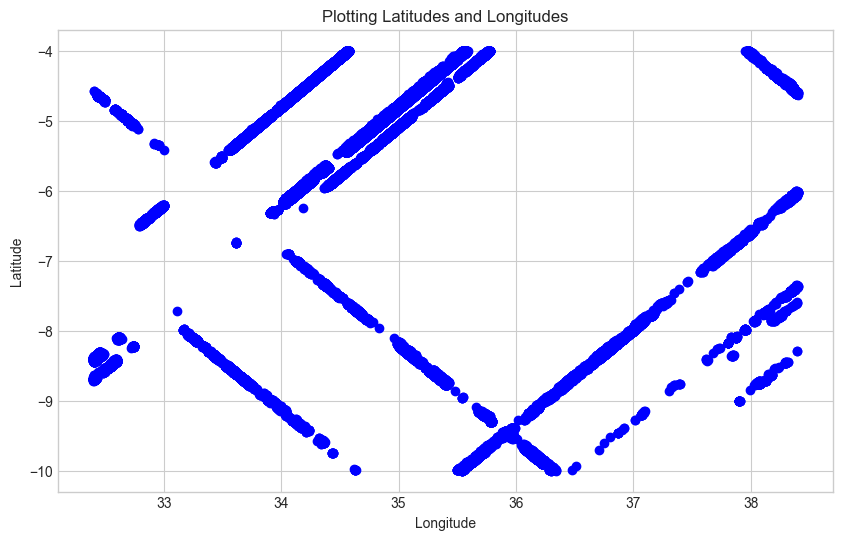

In [18]:
# first filtration of the data based on GEDI data exclusively 
min_lon = 32.4
max_lon = 38.4
min_lat = -10
max_lat = -4

filtered = l4adf[(l4adf['lat_lowestmode'] > min_lat) & (l4adf['lat_lowestmode'] < max_lat) & (l4adf['lon_lowestmode'] > min_lon) & (l4adf['lon_lowestmode'] < max_lon) & (l4adf['l4_quality_flag'] > 0) & (l4adf['agbd_se']/l4adf['agbd'] * 100 > 50)]

latitudes = filtered['lat_lowestmode'].values
longitudes = filtered['lon_lowestmode'].values

plt.figure(figsize=(10, 6))

plt.scatter(longitudes, latitudes, color='blue', marker='o')

plt.gca().set_facecolor('white')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plotting Latitudes and Longitudes')

plt.show()

In [19]:
filtered2 = filtered
filtered2.describe()

,agbd,agbd_se,elev_lowestmode,lat_lowestmode,lon_lowestmode,delta_time,l4_quality_flag
count,57182.000000,57182.000000,57182.000000,57182.000000,57182.000000,5.718200e+04,57182.0
mean,5.439548,5.548936,1206.484823,-6.030616,34.979881,8.415835e+07,1.0
std,7.849092,5.372529,474.077022,1.710277,1.349272,2.562034e+06,0.0
min,0.323698,2.991527,19.079802,-9.999735,32.400098,7.891812e+07,1.0
25%,1.116093,3.002255,998.623932,-7.855281,34.199436,8.346270e+07,1.0
50%,1.748223,3.006324,1312.144897,-5.254439,34.828666,8.448265e+07,1.0
75%,4.793548,3.008004,1534.022003,-4.666451,35.394944,8.639760e+07,1.0
max,34.255615,17.141457,2740.795654,-4.000001,38.399982,8.830636e+07,1.0


The DEM results have been obtained from https://portal.opentopography.org/raster?opentopoID=OTSDEM.032021.4326.3, the output format should be a zip file containing a visualisation and an output.tif 

In [20]:
# # this cell is to filter out data based on slopes but this leads to a lower spread of AGBD values

dem_file = 'output_COP30.tif'
dem_data = rasterio.open(dem_file)
dem_array = rd.rdarray(dem_data.read(1), no_data=-9999)
slopes = rd.TerrainAttribute(dem_array, attrib='slope_degrees')
transform = dem_data.transform

def coords_to_index(lat, lon, transform):
    # the inverse function to the transformation matrix to undo the transformation and convert lon/lat to rows/col on the tiff file
    col, row = ~transform * (lon, lat)
    return int(row), int(col)




def get_slope(lat, lon, transform, slopes):
    row, col = coords_to_index(lat, lon, transform)
    if 0 <= row < slopes.shape[0] and 0 <= col < slopes.shape[1]:
        return slopes[row, col]
    else:
        return np.nan  
    
filtered2['slope'] = filtered2.apply(lambda row: get_slope(row['lat_lowestmode'], row['lon_lowestmode'], transform, slopes), axis=1)

filtered2 = filtered2[filtered2['slope'] < 30]

filtered2.describe()

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 14.6528                         ] (7% - 193.8s - 1 threads))


,agbd,agbd_se,elev_lowestmode,lat_lowestmode,lon_lowestmode,delta_time,l4_quality_flag,slope
count,19249.000000,19249.000000,19249.000000,19249.000000,19249.000000,1.924900e+04,19249.0,19249.000000
mean,2.555917,3.704505,1115.828581,-5.845259,34.562968,8.473711e+07,1.0,16.426662
std,3.606474,2.918081,396.063578,1.499896,1.347657,2.434429e+06,0.0,8.075041
min,0.323698,2.991527,19.633318,-9.997543,32.400098,7.891812e+07,1.0,0.000000
25%,1.061925,3.003624,1022.356934,-7.021324,33.897003,8.346271e+07,1.0,9.678802
50%,1.228436,3.006673,1127.114624,-5.277471,34.451021,8.550264e+07,1.0,16.604429
75%,2.519921,3.007378,1373.118286,-4.718052,34.955805,8.720291e+07,1.0,23.465755
max,34.177357,17.141457,2646.296143,-4.000001,38.399639,8.830636e+07,1.0,29.998398


The following data have been obtained through https://viewer.esa-worldcover.org/worldcover/?language=en&bbox=-252.77343749999997,-76.47577254009317,252.77343749999997,76.47577254009315&overlay=false&bgLayer=OSM&date=2024-06-30&layer=WORLDCOVER_2021_MAP 

WorldCover Version 1 has been used

In [21]:
map_files = ['ESA_WorldCover_10m_2020_v100_S06E030_Map.tif', 'ESA_WorldCover_10m_2020_v100_S06E033_Map.tif', 'ESA_WorldCover_10m_2020_v100_S06E036_Map.tif', 'ESA_WorldCover_10m_2020_v100_S09E030_Map.tif', 'ESA_WorldCover_10m_2020_v100_S09E033_Map.tif', 'ESA_WorldCover_10m_2020_v100_S09E036_Map.tif', 'ESA_WorldCover_10m_2020_v100_S12E030_Map.tif', 'ESA_WorldCover_10m_2020_v100_S12E033_Map.tif', 'ESA_WorldCover_10m_2020_v100_S12E036_Map.tif']

for index,map in enumerate(map_files):
    map_dataset = rasterio.open(map)  
    layer1_map = map_dataset.read(1)
    
    transform = map_dataset.transform

    def get_map_code(lat, lon):
        col, row = ~transform * (lon, lat)
        try:
            if 0 <= int(row) < map_dataset.height and 0 <= int(col) < map_dataset.width:
                map_code = layer1_map[int(row), int(col)]
                return map_code
        except IndexError:
            return np.nan

    filtered2[f'map_code_{index}'] = filtered2.apply(lambda row: get_map_code(row['lat_lowestmode'], row['lon_lowestmode']), axis=1)

filtered2['map_code'] = filtered2[[f'map_code_{i}' for i in range(len(map_files))]].sum(axis=1, skipna=True)

filtered2.drop(columns=[f'map_code_{i}' for i in range(len(map_files))], inplace=True)

filtered2 = filtered2[(filtered2['map_code'] != 50) & (filtered2['map_code'] != 60) & (filtered2['map_code'] != 70) & (filtered2['map_code'] != 80) & (filtered2['map_code'] != 90) & (filtered2['map_code'] != 100)]

filtered2.describe()

,agbd,agbd_se,elev_lowestmode,lat_lowestmode,lon_lowestmode,delta_time,l4_quality_flag,slope
count,17742.000000,17742.000000,17742.000000,17742.000000,17742.000000,1.774200e+04,17742.0,17742.000000
mean,2.585789,3.709062,1121.606092,-5.850952,34.574883,8.470520e+07,1.0,16.624102
std,3.692003,2.934305,395.905780,1.502378,1.360013,2.430673e+06,0.0,7.966987
min,0.323698,2.991527,19.633318,-9.997543,32.400098,7.891812e+07,1.0,0.000000
25%,1.061925,3.003461,1022.777237,-7.021638,33.893737,8.346271e+07,1.0,10.027753
50%,1.228436,3.006673,1135.018005,-5.304912,34.466872,8.550263e+07,1.0,16.792244
75%,2.540479,3.007290,1374.218719,-4.695539,34.966764,8.720291e+07,1.0,23.536428
max,34.177357,17.141457,2646.296143,-4.000001,38.399639,8.830636e+07,1.0,29.998398


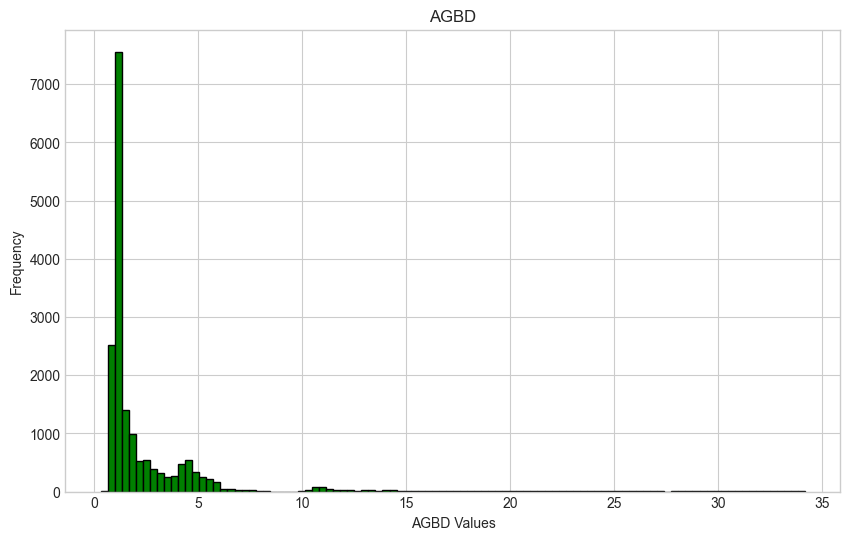

In [22]:
agbd_data = filtered2['agbd']

plt.figure(figsize=(10, 6)) 
plt.hist(agbd_data, bins=100, color='green', edgecolor='black')  
plt.xlabel('AGBD Values')
plt.ylabel('Frequency')
plt.title('AGBD')
plt.grid(True) 
plt.show()

The following code then splits the final results into 4 quadrants where each will be processed individually to be split into 100x100m cells

In [23]:
STEP = 100

gdf = gpd.GeoDataFrame(
    filtered2, 
    geometry=gpd.points_from_xy(filtered2.lon_lowestmode, filtered2.lat_lowestmode),
    crs="EPSG:4326"
)

bbox = gpd.GeoDataFrame(
    {'geometry': [Polygon([(min_lon, min_lat), (min_lon, max_lat), 
                           (max_lon, max_lat), (max_lon, min_lat), 
                           (min_lon, min_lat)])]},
    crs="EPSG:4326"
)

utm_crs = bbox.estimate_utm_crs()

min_x, min_y, max_x, max_y = bbox.to_crs(utm_crs).total_bounds

mid_x = (min_x + max_x) / 2
mid_y = (min_y + max_y) / 2

quadrants = [
    (min_x, min_y, mid_x, mid_y), 
    (mid_x, min_y, max_x, mid_y), 
    (min_x, mid_y, mid_x, max_y), 
    (mid_x, mid_y, max_x, max_y)   
]

In [24]:
def create_grid(min_x, min_y, max_x, max_y, step):
    return [
        box(minx, miny, maxx, maxy)
        for minx, maxx in zip(np.arange(min_x, max_x, step), np.arange(min_x, max_x, step)[1:])
        for miny, maxy in zip(np.arange(min_y, max_y, step), np.arange(min_y, max_y, step)[1:])
    ]
    
results = []

In [25]:
#for bottom left quadrant, each quadrant seperated to avoid runtime error
grid = create_grid(min_x, min_y, mid_x, mid_y, STEP)
gdf_grid = gpd.GeoDataFrame(geometry=grid, crs=utm_crs).to_crs(bbox.crs)
gdf_joined = gpd.sjoin(gdf, gdf_grid, how="left", predicate="within")
quadrant_result = (
        gdf_joined.groupby("index_right")
        .agg(count=("agbd", "size"), avg_agbd=("agbd", "mean"))
        .reset_index()
)
results.append(quadrant_result)

In [26]:
#for bottom right
grid = create_grid(mid_x, min_y, max_x, mid_y, STEP)
gdf_grid = gpd.GeoDataFrame(geometry=grid, crs=utm_crs).to_crs(bbox.crs)
gdf_joined = gpd.sjoin(gdf, gdf_grid, how="left", predicate="within")
quadrant_result = (
        gdf_joined.groupby("index_right")
        .agg(count=("agbd", "size"), avg_agbd=("agbd", "mean"))
        .reset_index()
)
results.append(quadrant_result)

In [27]:
#for top left
grid = create_grid(min_x, mid_y, mid_x, max_y, STEP)
gdf_grid = gpd.GeoDataFrame(geometry=grid, crs=utm_crs).to_crs(bbox.crs)
gdf_joined = gpd.sjoin(gdf, gdf_grid, how="left", predicate="within")
quadrant_result = (
        gdf_joined.groupby("index_right")
        .agg(count=("agbd", "size"), avg_agbd=("agbd", "mean"))
        .reset_index()
)
results.append(quadrant_result)

In [28]:
#for top right
grid = create_grid(mid_x, mid_y, max_x, max_y, STEP)
gdf_grid = gpd.GeoDataFrame(geometry=grid, crs=utm_crs).to_crs(bbox.crs)
gdf_joined = gpd.sjoin(gdf, gdf_grid, how="left", predicate="within")
quadrant_result = (
        gdf_joined.groupby("index_right")
        .agg(count=("agbd", "size"), avg_agbd=("agbd", "mean"))
        .reset_index()
)
results.append(quadrant_result)

In [29]:
final_result = pd.concat(results, ignore_index=True)

Only cells with >= 3 results will be stored

In [1]:
result_filtered = final_result[final_result['count'] > 2]

final_result_2 = gdf_grid.merge(result_filtered, left_index=True, right_on="index_right")
final_result_2 = final_result_2.drop(columns=["index_right"])

final_result_2['bbox'] = final_result_2.geometry.apply(lambda geom: geom.bounds)

final_result_2.describe()

NameError: name 'final_result' is not defined

In [37]:
final_result_2.to_csv("AGBD_cells.csv", index=False)